In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Import Data

In [2]:
# # 1k data
df_train = pd.read_csv('df_train_1k.csv')
df_test = pd.read_csv('df_test_1k.csv')

# # 10k data
# df_train = pd.read_csv('df_train.csv')
# df_test = pd.read_csv('df_test.csv')

# Batching 

In [3]:
grouped_data_train = [group for _, group in df_train.groupby('uid')]
grouped_data_test = [group for _, group in df_test.groupby('uid')]

# Sliding window by 1 STEP
STEP_SIZE = 12
WINDOW_SIZE = 10
class TrajectoryDataset(Dataset):
    def __init__(self, grouped_data):
        self.data = []
        for group in grouped_data:
            if len(group) >= STEP_SIZE:
                # get the first STEP_SIZE location and time data
                xy = group['combined_xy'].values.tolist()[:STEP_SIZE]
                t = group['t'].values.tolist()[:STEP_SIZE]
                # slice the data into several sessions using moving window approach
                self.data.extend([(xy[i:i+WINDOW_SIZE], t[i:i+WINDOW_SIZE])
                                  for i in range(STEP_SIZE-WINDOW_SIZE+1)])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        xy_window, t_window = self.data[idx]
        inputs = torch.tensor(xy_window[:-1]) # input sequence of locations
        labels = torch.tensor(xy_window[-1]) # desired predicted location
        positions = torch.tensor(t_window[:-1]) # corresponding input locations' times
        label_positions = torch.tensor(t_window[-1]) # corresponding predicted location's time
        return inputs, labels, positions, label_positions

# Sliding window by STEP_SIZE
STEP_SIZE = 20
WINDOW_SIZE = 10
class TrajectoryDatasetTEST(Dataset):
    def __init__(self, grouped_data):
        self.data = []
        for group in grouped_data:
            if len(group) >= STEP_SIZE:
                
                # get the first STEP_SIZE location and time data
                xy = group['combined_xy'].values.tolist()[:STEP_SIZE]
                t = group['t'].values.tolist()[:STEP_SIZE]
                
                # slice the data into several sessions using moving window approach
                self.data.extend([(xy[i:i+WINDOW_SIZE], t[i:i+WINDOW_SIZE])
                                  for i in range(0, STEP_SIZE-WINDOW_SIZE+1, STEP_SIZE)])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        xy_window, t_window = self.data[idx]
        inputs = torch.tensor(xy_window[:-1]) # input sequence of locations
        labels = torch.tensor(xy_window[-1]) # desired predicted location
        positions = torch.tensor(t_window[:-1]) # corresponding input locations' times
        label_positions = torch.tensor(t_window[-1]) # corresponding predicted location's time
        return inputs, labels, positions, label_positions

train_dataset = TrajectoryDataset(grouped_data_train) 
test_dataset = TrajectoryDatasetTEST(grouped_data_test)

def collate_fn(batch):
    # Unzip all batch
    inputs_batch, labels_batch, positions_batch, label_positions_batch = zip(*batch)
    # Pad the sequence with less length in a batch
    inputs_padded = torch.nn.utils.rnn.pad_sequence(inputs_batch, padding_value=0.0, batch_first=True) 
    labels_padded = torch.tensor(np.array(labels_batch))
    positions_padded = torch.nn.utils.rnn.pad_sequence(positions_batch, padding_value=0, batch_first=True) 
    label_positions_padded = torch.tensor(np.array(label_positions_batch))
    return inputs_padded, labels_padded, positions_padded, label_positions_padded

BATCH_SIZE = (len(train_dataset) // len(grouped_data_train)) * 10

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

# LSTM
https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/

### Model Building (nn.PyTorch built-in LSTM)

In [4]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, loc_size, embed_dim, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.input_embedding = nn.Embedding(loc_size, embed_dim)
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, loc_size)
        self.num_layers = num_layers
        self.hidden_size = hidden_size

    def forward(self, x):
        # positioanl embedding
        x = self.input_embedding(x)
        
        # initiation
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  
        
        # getting output
        out, _ = self.lstm(x, (h0, c0)) 
        out = self.fc(out[:, -1, :])
        return out

### Training

In [5]:
# Model related param
model = LSTMModel(loc_size=40000, 
                  embed_dim=256, 
                  hidden_size=256, # not sure about this
                  num_layers=2)
optimizer = optim.Adam(model.parameters(), lr=0.0013)
criterion = nn.CrossEntropyLoss()

In [6]:
epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, labels, positions, label_positions in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.long()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    print(f"Epoch: {epoch}: Average Loss: {total_loss/len(train_dataloader)}")

Epoch: 0: Average Loss: 9.741778075695038
Epoch: 1: Average Loss: 7.058310002088547
Epoch: 2: Average Loss: 5.105363833904266
Epoch: 3: Average Loss: 3.6240102767944338
Epoch: 4: Average Loss: 2.6407378911972046


```
# 10k, 2 epochs
Epoch: 0: Average Loss: 7.053878789760357
Epoch: 1: Average Loss: 4.725554961066872

# 10k, 5 epochs
Epoch: 0: Average Loss: 6.868251155039734
Epoch: 1: Average Loss: 4.685292274341162
Epoch: 2: Average Loss: 4.105947904996041
Epoch: 3: Average Loss: 3.7265372524335882
Epoch: 4: Average Loss: 3.4117784090873013
```

# Inference

In [7]:
import torch.nn.functional as F

In [8]:
def evaluate_model_with_top_k(model, dataloader, device, k):
    model.eval()
    total_correct = 0
    total_examples = 0
    
    with torch.no_grad():
        for inputs, labels, positions, label_positions in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.long()
            
            logits = model(inputs)
            
            if (BATCH_SIZE > 1):
                for logit_i in range(len(logits)):
                    tolerated_acc = int(labels[logit_i] in torch.topk(logits[logit_i], k)[1])
                    total_correct += tolerated_acc
            else:
                tolerated_acc = int(labels in torch.topk(logits, k)[1])
                total_correct += tolerated_acc

            total_examples += labels.numel()
    
    print(f"Batch Size: {BATCH_SIZE} Top {k} Accuracy: {total_correct/total_examples}, Num Correct: {total_correct}, Num Sample: {total_examples}")
    
    return total_correct/total_examples

In [9]:
lstm_accuracy = evaluate_model_with_top_k(model, test_dataloader, device, 1)

Batch Size: 110 Top 1 Accuracy: 0.02, Num Correct: 4, Num Sample: 200


```
# 1k, 5 epochs, top 1
Batch Size: 110 Top 1 Accuracy: 0.02, Num Correct: 4, Num Sample: 200

# 10k, 2 epochs, top 5
Batch Size: 910 Top 5 Accuracy: 0.30905343392704365, Num Correct: 55629, Num Sample: 179998

# 10k, 5 epochs, top 1
Batch Size: 910 Top 1 Accuracy: 0.12364581828686985, Num Correct: 22256, Num Sample: 179998
```

# Visualization

In [10]:
import matplotlib.pyplot as plt

In [11]:
frequent_locations = [(152, 95), (152, 95), (152, 95), (152, 95), (152, 95), (152, 95), (152, 95), (152, 95), (178, 34), (125, 137), (158, 64), (125, 137), (152, 95), (130, 63), (129, 81), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (152, 95), (152, 95), (152, 95)]

In [12]:
# extract correct or incorrect prediction for visualization
def extract_prediction(model, dataloader, device, k, extract_correct):
    model.eval()
    with torch.no_grad():
        for inputs, labels, positions, label_positions in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.long()
            
            logits = model(inputs)
            
            for logit_i in range(len(logits)):
                if (extract_correct):
                    if (int(labels[logit_i] in torch.topk(logits[logit_i], k)[1])):
                        return inputs[logit_i].tolist(), \
                                labels[logit_i].item(), \
                                positions[logit_i].tolist(), \
                                label_positions[logit_i].item(), \
                                torch.topk(logits[logit_i], k)[1].item()
                else:
                    if (int(labels[logit_i] not in torch.topk(logits[logit_i], k)[1])):
                        return inputs[logit_i].tolist(), \
                                labels[logit_i].item(), \
                                positions[logit_i].tolist(), \
                                label_positions[logit_i].item(), \
                                torch.topk(logits[logit_i], k)[1].item()

In [13]:
def plot_trajectory(inputs, labels, positions, label_positions, prediction, display_frequent): 
    """
    inputs: List<int>: trajctory of a user; a list of location-id a user has stepped through
    labels: int: the desired location-id or the label of the model prediction
    positions: List<int>: corresponding time recorded in each of the trajectory data above
    label_positions: int: corresponding time of the recorded label location-id
    prediction: int: the predicted location-id made by the model
    display_frequent: boolean: whether or not to display the most frequently visited location
    """
    
    # Determine if the prediction is correct
    false_prediction = True
    if (prediction == labels): 
        false_prediction = False
        
    fig, ax = plt.subplots(figsize=(5,5))
    
    # Plot the trajectory (blue line)
    inputs = df_train[df_train['combined_xy'].isin(inputs)]
    ys = list(inputs['y'])
    xs = list(inputs['x'])
    ax.plot(xs, ys, label='Trajectory', linewidth=0.5)
    ax.scatter(xs, ys)

    # # Trajectory Time Annotation
    # for i in range(len(positions)):
        # ax.annotate(str(positions[i]), (inputs.iloc[i]['x'], inputs.iloc[i]['y']), 
        # textcoords="offset points", xytext=(0,10), ha='center')
    
    # Plot label (green dot)
    df_train_labels = df_train[df_train['combined_xy']==labels].iloc[0] # def
    labels = (df_train_labels['x'], df_train_labels['y'])
    ax.plot(*labels,'go', label='Actual Location') 
    
    # # Label Time Annotation
    # ax.annotate(str(label_positions), labels, textcoords="offset points", 
    # xytext=(0,10), ha='center')

    # If false prediction: plot predicted location (red dot)
    if false_prediction:
        df_train_prediction = df_train[df_train['combined_xy']==prediction].iloc[0] # def
        prediction = (df_train_prediction['x'], df_train_prediction['y'])
        ax.plot(*prediction, 'ro', label='Predicted Location')
    
    # If request display_requent: plot frequently visited location (purple dot)
    if display_frequent:
        frequent = frequent_locations[label_positions]
        ax.plot(*frequent, 'mo', label='Frequent Location')
        
    # # Setting up the legend and labels
    # ax.set_xlim(0, 200)
    # ax.set_ylim(0, 200)
    # ax.set_xticks(range(0, 201, 1))
    # ax.set_yticks(range(0, 201, 1))
    ax.grid(True)
    ax.set_xlabel('X-Coordinate')
    ax.set_ylabel('Y-Coordinate')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

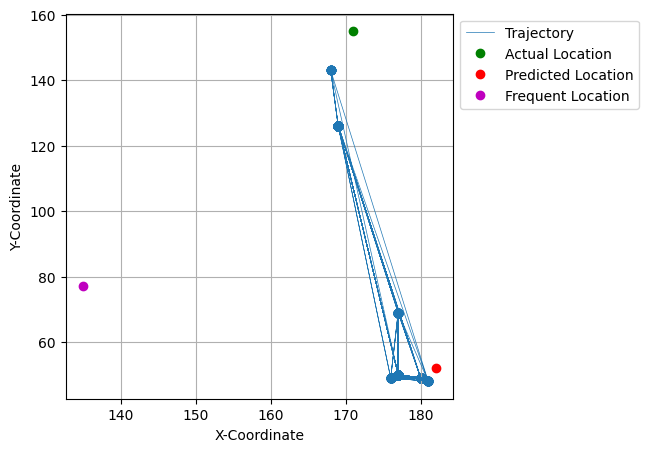

In [14]:
inputs,labels,positions,label_positions,prediction = \
            extract_prediction(model,test_dataloader,device,1,False)
plot_trajectory(inputs, labels, positions, label_positions, prediction,True)

# Hyperparameter-tuning

In [ ]:
import optuna


batch_sizes = [int(i) for i in range(5,101,5)]
batch_sizes.append(1)
batch_sizes = sorted(batch_sizes)


def objective(trial):
    # Set up dataloader
    batch_size = trial.suggest_categorical('batch_size', batch_sizes)  ##
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    
    # Model Parameters
    NUM_CLASS = 40000
    STEP_SIZE = 100
    # EMBED_DIM = trial.suggest_categorical('embed_dim', [64, 128, 256, 512])
    EMBED_DIM = 256
    LAYER_DIM = trial.suggest_int('layer_dim', 1, 6)  ##
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Train the model
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    
    # Model instantiation
    model = LSTMModel(input_dim=1,
                      embed_dim=EMBED_DIM, 
                      layer_dim=LAYER_DIM,
                      output_dim=NUM_CLASS)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    # Training loop
    total_loss = 0
    total_samples = 0
    for epoch in range(5):
        model.train()
        for inputs, labels in train_dataloader:
            inputs = inputs.float().unsqueeze(-1)
            labels = labels.long()
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * labels.size(0)
            total_samples += labels.size(0)
    
    final_avg_loss = total_loss / total_samples
    return final_avg_loss

# Hyperparameter tuning

# Create a study object and optimize the objective function
study = optuna.create_study()
study.optimize(objective, n_trials=50)

# Result
print('Best parameters:', study.best_params)
print('Best loss:', study.best_value)